## Рекомендательные системы: предсказание оценки

Рассмотрим задачу предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Данные: [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

Задача: построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

Метрика качества: будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.
Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.
Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1. (1 балл)** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен.

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [136]:
#Для начала нам надо переиндексировать индексы пользователей и фильмов, иначе будет неудобно работать с csr матрицей.Создадим копию, чтобы на основе нее менять индексы в основной  
user_rate = pd.read_csv('D://hw4//user_ratedmovies-timestamps.dat', sep='\t')
user_rate_copyed = user_rate.copy()

In [137]:
movie_un = {}
user_un = {}
count_movie = 0
count_user = 0

In [140]:
#iterrows выдает нам значения и индексы по строкеы.
#Пробегаем в цикле по всем айдишникам,и когда находим новый, то присваемваем ему значение +1 от предытущего(в данном случаем сдела индексацию от 0)
for index, row in user_rate.iterrows():
    movie_id= int(row["movieID"])
    user_id = int(row["userID"])
    if movie_id not in movie_un.keys():
        movie_un[movie_id] = count_movie
        count_movie += 1
    if user_id not in user_un.keys():
        user_un[user_id] = count_user

        count_user += 1

In [141]:
#Заполняем датафрейм с новыми индексами
for index, row in user_rate_copyed.iterrows():
    user_id = int(row["userID"])
    movie_id = int(row["movieID"])
    
    user_rate.set_value(index, "userID", user_un[user_id])
    user_rate.set_value(index, "movieID", movie_un[movie_id])
del user_rate_copyed

In [142]:
#Cортируем по user_id и#Cортируем по user_id и timestamp,получается так что сортировка по времени происходит по каждому юзеру
user_rate = user_rate.sort_values(['userID', 'timestamp'])

In [144]:
user_rate.head()

,userID,movieID,rating,timestamp
25,0,25,2.0,1162160199000
9,0,9,2.0,1162160202000
3,0,3,2.0,1162160212000
19,0,19,2.5,1162160216000
8,0,8,3.5,1162160220000


In [41]:
uniq_u = np.unique(user_rate['userID'])
uniq_m = np.unique(user_rate['movieID'])
print(len(uniq_u),len(uniq_m))

2113 10109


In [39]:
user_rate[user_rate['userID'] == 0][-5:]

,userID,movieID,rating,timestamp
50,0,50,5.0,1162160691000
51,0,51,3.5,1162160928000
52,0,52,3.5,1162160924000
53,0,53,3.5,1162160758000
54,0,54,4.5,1162160986000


In [145]:
#Cоздаем три датасета для тестовой , обучуающей и валидационой выборки , чтобы в дальнейшем перевести их в матрицы.
k = 5
x_test = pd.DataFrame(columns=['userID','movieID', 'rating', 'timestamp'])
x_valid = pd.DataFrame(columns=['userID','movieID', 'rating', 'timestamp'])
x_train = pd.DataFrame(columns=['userID','movieID', 'rating', 'timestamp'])
for user in uniq_u:
    row = user_rate[user_rate['userID'] == user]
    x_test = x_test.append(row[-k:])
    x_valid = x_valid.append(row[-2*k:-k])
    x_train = x_train.append(row[:-2*k])

In [48]:
x_test.shape

(10565, 4)

In [53]:
#Cоздаем три искомы разряженный матрицы.
from scipy.sparse import csr_matrix
test_matrix = csr_matrix((x_test['rating'], (x_test['userID'], x_test['movieID'])), shape=(len(uniq_u), len(uniq_m))).toarray()
train_matrix = csr_matrix((x_train['rating'], (x_train['userID'], x_train['movieID'])), shape=(len(uniq_u), len(uniq_m))).toarray()
valid_matrix = csr_matrix((x_valid['rating'], (x_valid['userID'], x_valid['movieID'])), shape=(len(uniq_u), len(uniq_m))).toarray()

In [54]:
print(test_matrix.shape)
print(train_matrix.shape)
print(valid_matrix.shape)

(2113, 10109)
(2113, 10109)
(2113, 10109)


Качество рекомендаций: будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Также можно использовать метрику качества ранжирования. Для этого для каждого пользователя $u$ предскажем оценку для всех фильмов из $R^u_{test}$ и отсортируем эти фильмы по убыванию предсказанного рейтинга. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Тогда nDCG@k :

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

Положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2. (2 балла)** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

In [69]:
len(test_matrix[1])

10109

In [107]:
def rmse_score(y_true, y_predicted, k=5):
    
    
    if type(y_true) == sparse.csr.csr_matrix:
        y_true = y_true.toarray()
    else:
        y_true = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted = y_predicted.toarray()
    else:
        y_predicted = y_predicted
        
    user_num = y_predicted.shape[0]
    rmse_ku= int(0)
    rmse_k = int(0)
    #Здесь мы в цикле пробегаемся по всем юзерам
    for user in range(user_num):
        #функция аргсор возвращает позиции для отстортированного массива, но не соритрует его.
        movie_id = y_predicted[user].argsort()[-k:]
        true_k = []
        pred_k = []
        #Зная id всех топ_к фильмов , добавляем их в список и высчитываем rmse
        for mov in movie_id:
            true_k.append(y_true[user][mov])
            pred_k.append(y_predicted[user][mov])
        for  i in range(len(pred_k)):
            dif  = (pred_k[i] - true_k[i]) ** 2
            rmse_ku += dif
        rmse_ku = np.sqrt(rmse_ku/k)
        rmse_k += rmse_ku
    rmse_k = rmse_k/user_num

    return rmse_k

def ndcg_score(y_true, y_predicted, k=5):
    
    if type(y_true) == sparse.csr.csr_matrix:
        y_true = y_true.toarray()
    else:
        y_true = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted = y_predicted.toarray()
    else:
        y_predicted = y_predicted
    
    user_num = y_predicted.shape[0]
    dcg = int(0)
    dcg_ku = []
    ndcg_ku = []
    for user in range(user_num):
        movie_id = y_predicted[user].argsort()[-k:]
        true_k_dcg = []
        pred_k_dcg= []
        for mov in movie_id:
            true_k_dcg.append(y_true[user][mov])
            pred_k_dcg.append(y_predicted[user][mov])
        for i in range(len(true_k_dcg)):
            dcg +=  (2 ** (true_k_dcg[i]) - 1)/(np.log2(i+1) + 1)
        dcg_ku.append(dcg)
    max_dcg = max(dcg_ku)
    for j in dcg_ku:
        ndcg_ku.append(j/max_dcg)
    ndcg_ku = sum(ndcg_ku)/user_num
    
    return ndcg_ku

**3. (1 балл)** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

In [112]:
test_matrix[:,1]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [115]:
#Здесь мы пробегаемся по всем фильмам и находим пользователей, у которых рейтинг для этого фильма нулевой и заменяем его на среднее значение рейтинга для этого фильма срзди всех пользователей 
most_pop = np.zeros((test_matrix.shape[0], test_matrix.shape[1]))
movie_num = test_matrix.shape[1]
mean_raiting = {}
#создаем словарь с средними значениями для конкретного фильма
for i in range(movie_num):
    count = 0
    for j in train_matrix[:, i]:
        if j != 0:
            count += 1
            mean_raiting[i] = mean_raiting.get(i, 0) + j
    if count != 0:
        mean_raiting[i] = mean_raiting[i]/count
#заполняе матрицу most_pop
for mov_id, raiting in mean_raitig.items():
    for userID in range(most_pop.shape[0]):
        most_pop[userID][movieID] = rating

In [116]:
rmse_score(test_matrix, most_pop, k=5)

0.20604601842496878

In [117]:
ndcg_score(test_matrix, most_pop, k= 5)

0.51497507436002299

**4. (1 балл)** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения)

In [69]:
from sklearn.decomposition import TruncatedSVD

In [121]:
#Признаюсь, я ненмного туповат и в данном и следующим задании я опирался на знания из статьи https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html
import scipy.sparse as sp
from scipy.sparse.linalg import svds


rmse_vals = []
ndcge_vals = []

for r in np.arange(10, 110, 10):
    print('rank', r)
    u, s, vt = svds(train_matrix, k = r)
    s_diag_matrix=np.diag(s)
    pred = np.dot(np.dot(u, s_diag_matrix), vt)
    cur_rmse = rmse_score(valid_matrix, pred)
    cur_ndcg = ndcg_score(valid_matrix, pred)
    rmse_vals.append(cur_rmse)
    ndcge_vals.append(cur_ndcg)
    print('rmse', cur_rmse)
    print('ndcg', cur_ndcg)

rank 10
rmse 3.62577274487
ndcg 0.450013390606
rank 20
rmse 3.92084493911
ndcg 0.513804446291
rank 30
rmse 4.07327738904
ndcg 0.491774231485
rank 40
rmse 4.20367216903
ndcg 0.50673596079
rank 50
rmse 4.28864080697
ndcg 0.563812757514
rank 60
rmse 4.35233944871
ndcg 0.472142616894
rank 70
rmse 4.4105493893
ndcg 0.439489561837
rank 80
rmse 4.46864110404
ndcg 0.493457882247
rank 90
rmse 4.50650318589
ndcg 0.48332188326
rank 100
rmse 4.54376883316
ndcg 0.481723024618


Text(0.5,0,'rank')

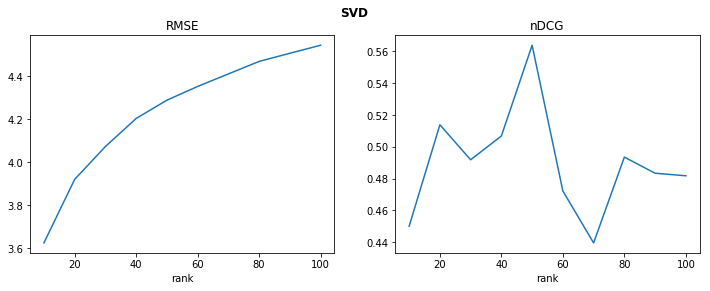

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
args = np.arange(10, 110, 10)

fig.suptitle('SVD', fontweight='bold')
ax1.plot(args, rmse_vals)
ax2.plot(args, ndcge_vals)
ax1.set_title('RMSE')
ax2.set_title('nDCG')
ax1.set_xlabel('rank')
ax2.set_xlabel('rank')

**5. (3 балла)** Постройте рекомендации на основе user-based коллаборативной фильтрации. 
Предсказание модели $\hat{r}_{ui}$ вычисляйте по следующей формуле:
$$\hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_{v \in U(u)} w_{uv} (r_{vi} - \bar{r}_v)}{\sum_{v \in U(u)} w_{uv}},$$
где $\bar{r}_u$ — средний ретинг пользователя $u$, $w_{uv}$ — мера сходства пользователей $u$ и $v$, $U(u) = \{ v \in U \, | \, w_{uv} > \alpha\}$ — коллаборация пользователя $u$. 

Значение параметра $\alpha$ возьмите равным 0.9.

Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке.

In [124]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_matrix, metric='cosine')

def predict(ratings, similarity):
    mean_user_rating = ratings.mean(axis=1)
    ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
    pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred

user_prediction = predict(test_matrix, user_similarity)


In [128]:
rmse_score(user_prediction,test_matrix)

3.7508386499043369

In [129]:
ndcg_score(user_prediction,test_matrix)

0.50150102704684529

**6. (1 балл)** Какой метод оказался лучше по каким метрикам? Почему?

Лучший результат получился у метода most_pop, но с аномально малым результатом и сам метод делает довольно грубую оценку, так что будем сравнивать User-Based Collaborative Filtering и SVD.

Метод SVD показал ухудшение с ростом к показания rmse ухудшались, а dcg как возрастали , так и убывали, это может объяснено делелнием на логарифм.
В данном методе может возникнуть проблема того, что есть не единственный способ разложения матрицы. 


Метод user_based показал результат чуть хуже , чем SVD  при малых значения rank.
Данный метод работает довольно хорошо, но имеет несколько недостатков. При появления новых или нестандартных пользователей им будет нечего рекомендовать, так же встает вопрос , что если данный фильм никто не посмотрел, то он тоже не будет рекомендован.


**7. (1 балл)** Приведите достоинства и недостатки используемых метрик. Какие еще метрики можно было бы использовать для решения задачи? Приведите примеры других постановок задачи, как в этом случае можно было бы оценить качество?

RMSE.


Оценки как показатель довольно субъективный критерий ведь у каждого свое представления о хорошем кино и тут нет единого стандарта, поэтому возникает довольно большой разброс.
И получается так, что пользователи имеющие большой разброс оценок, будут иметь бОльший вес.


DCG

Данный метод дает лучшие результаты и явлеется более релевантным для рекомендательных систем.
Данный метод довольно  зависит как от порядка, так и от релевантности фильма.Не сильно зависит от небольших значений ранга k, но довольно сильно зависит от релевантности фильма.

Precision и Recall метод.

Нет данных про рекомендованные объекты, которые пользователь не оценивал.
Оптимизировать эти метрики напрямую почти невозможно.

На самом деле задач из класса рекомендательных систем довольно большое количество, таргетная реклама, запросы пользователей, подбор товаров в интеренет магазинах, подборка музыки,видео(youtube) и тд.


Ну и в основном есть три основных подхода к решению данного класса задач.

Collaborative Filtering(Основывается на взаимодействии пользователь - объект,по сути заполнения матрицы пользователь - объект на основании)(user-based, item-based)

Content Based system (Основывается на характеристических признаков объектов)

Knowledge based system(экспертное мнение о рекомендациях)